<div style="width: 100%">
     <center>
    <img style="width: 100%" src="https://storage.googleapis.com/kaggle-competitions/kaggle/26680/logos/header.png?t=2021-04-23-22-04-05"/>
    </center>
</div>

<h1 id="title" style="color:white;background:black;">
    </br>
    <center>
        SIIM-FISABIO-RSNA COVID-19 Detection - Basic EDA
    </center>
</h1>

# 1. Introduction
> we'll identify and localize COVID-19 abnormalities on chest radiographs. In particular, you'll categorize the radiographs as negative for pneumonia or typical, indeterminate, or atypical for COVID-19. we need to make predictions at both a `study` (multi-image) and `image` level.

## 1.1. Study-level labels
> Studies in the test set may contain more than one label.

> `negative`, `typical`, `indeterminate`, `atypical`

## 1.2. Image-level labels
> Images in the test set may contain more than one object.

> you must predict a `class ID` of "opacity", a `confidence score`, and `bounding box` in format xmin ymin xmax ymax.
(`none` is the class ID for "No finding".)

## 1.3. Evaluation Metrics
> the standard PASCAL VOC 2010 `mean Average Precision (mAP)` at IoU > `0.5`

> Here is no concept of `difficult` classes in VOC 2010(Perhaps VOC 2012 will have that concept.).

  You can see more details in [mAP understanding with code and its tips](https://www.kaggle.com/its7171/map-understanding-with-code-and-its-tips) for understanding it.

# 2. Importing the libraries📗

In [ ]:
!pip install gdcm

     |████████████████████████████████| 2.7 MB 4.4 MB/s 


In [ ]:
import os
from os import listdir
import pandas as pd
import numpy as np
import glob
from skimage import exposure
import matplotlib.pyplot as plt
%matplotlib inline

# pydicom
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from fastai.imports import *
from fastai.medical.imaging import *

import cv2

# color
from colorama import Fore, Back, Style

import seaborn as sns
sns.set(style="whitegrid")

# plotly
import plotly.express as px
import plotly

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# Settings for pretty nice plots
plt.style.use('fivethirtyeight')
plt.show()

# 3. Reading the csv📚

In [ ]:
# List files available
list(os.listdir("../input/siim-covid19-detection"))

['sample_submission.csv',
 'train_image_level.csv',
 'test',
 'train',
 'train_study_level.csv']

In [ ]:
IMAGE_PATH = "../input/siim-covid19-detection/"

train_study_df = pd.read_csv('../input/siim-covid19-detection/train_study_level.csv')
train_image_df = pd.read_csv('../input/siim-covid19-detection/train_image_level.csv')

print(Fore.YELLOW + 'Train study df shape: ',Style.RESET_ALL,train_study_df.shape)
print(Fore.YELLOW + 'Train image df shape: ',Style.RESET_ALL,train_image_df.shape)

Train study df shape:   (6054, 5)
Train image df shape:   (6334, 4)


In [ ]:
display(train_study_df.head(5))
display(train_image_df.head(5))

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0
3,005057b3f880_study,1,0,0,0
4,0051d9b12e72_study,0,0,0,1


,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]",opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867.79767, 'height': 999.78214}, {'x': 1792.69064, 'y': 402.5525, 'width': 617.02734, 'height': 1204.358}]",opacity 1 677.42216 197.97662 1545.21983 1197.75876 opacity 1 1792.69064 402.5525 2409.71798 1606.9105,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.00012, 'height': 604}]",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'height': 1106}, {'x': 2578.56661, 'y': 998.66667, 'width': 662.66667, 'height': 1120}]",opacity 1 623.23328 1050 1337.23328 2156 opacity 1 2578.56661 998.66667 3241.23328 2118.66667,dfd9fdd85a3e


In [ ]:
sample_submission = pd.read_csv('../input/siim-covid19-detection/sample_submission.csv')
print(Fore.YELLOW + 'Sample submission df shape: ',Style.RESET_ALL,sample_submission.shape)
display(sample_submission)

Sample submission df shape:   (2477, 2)


,id,PredictionString
0,00188a671292_study,negative 1 0 0 1 1
1,004bd59708be_study,negative 1 0 0 1 1
2,00508faccd39_study,negative 1 0 0 1 1
3,006486aa80b2_study,negative 1 0 0 1 1
4,00655178fdfc_study,negative 1 0 0 1 1
...,...,...
2472,46719b856de1_image,none 1 0 0 1 1
2473,31c07523a69a_image,none 1 0 0 1 1
2474,f77d7d1aebab_image,none 1 0 0 1 1
2475,ccc5b63ca96d_image,none 1 0 0 1 1


For each test study, we should make a determination within the following labels.

- `Negative for Pneumonia`

- `Typical Appearance`

- `Indeterminate Appearance`

- `Atypical Appearance`

For each test image, we will be predicting a bounding box and class for all findings.
- e.g. `none 1 0 0 1 1`

# 4. Basic Data Exploration 

## General Info

In [ ]:
# Null values and Data types
print(Fore.BLUE + 'Train Study Set !!',Style.RESET_ALL)
print(train_study_df.info())
print('-------------')
print(Fore.YELLOW + 'Train Image Set !!',Style.RESET_ALL)
print(train_image_df.info())

Train Study Set !! 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6054 entries, 0 to 6053
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        6054 non-null   object
 1   Negative for Pneumonia    6054 non-null   int64 
 2   Typical Appearance        6054 non-null   int64 
 3   Indeterminate Appearance  6054 non-null   int64 
 4   Atypical Appearance       6054 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 236.6+ KB
None
-------------
Train Image Set !! 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6334 entries, 0 to 6333
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                6334 non-null   object
 1   boxes             4294 non-null   object
 2   label             6334 non-null   object
 3   StudyInstanceUID  6334 non-null   object
dtypes: object(4)
memor

## Missing values

In [ ]:
train_study_df.isnull().sum()

id                          0
Negative for Pneumonia      0
Typical Appearance          0
Indeterminate Appearance    0
Atypical Appearance         0
dtype: int64

In [ ]:
train_image_df.isnull().sum()

id                     0
boxes               2040
label                  0
StudyInstanceUID       0
dtype: int64

`2040` : It seems missing bounding boxes.

## 4.1 Basic Data Exploration for `Study level` 

In [ ]:
train_study_df.head()

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0
3,005057b3f880_study,1,0,0,0
4,0051d9b12e72_study,0,0,0,1


In [ ]:
display(train_study_df['Negative for Pneumonia'].value_counts())
display(train_study_df['Typical Appearance'].value_counts())
display(train_study_df['Indeterminate Appearance'].value_counts())
display(train_study_df['Atypical Appearance'].value_counts())

0    4378
1    1676
Name: Negative for Pneumonia, dtype: int64

0    3199
1    2855
Name: Typical Appearance, dtype: int64

0    5005
1    1049
Name: Indeterminate Appearance, dtype: int64

0    5580
1     474
Name: Atypical Appearance, dtype: int64

There are `4` labels in `train study level.csv`

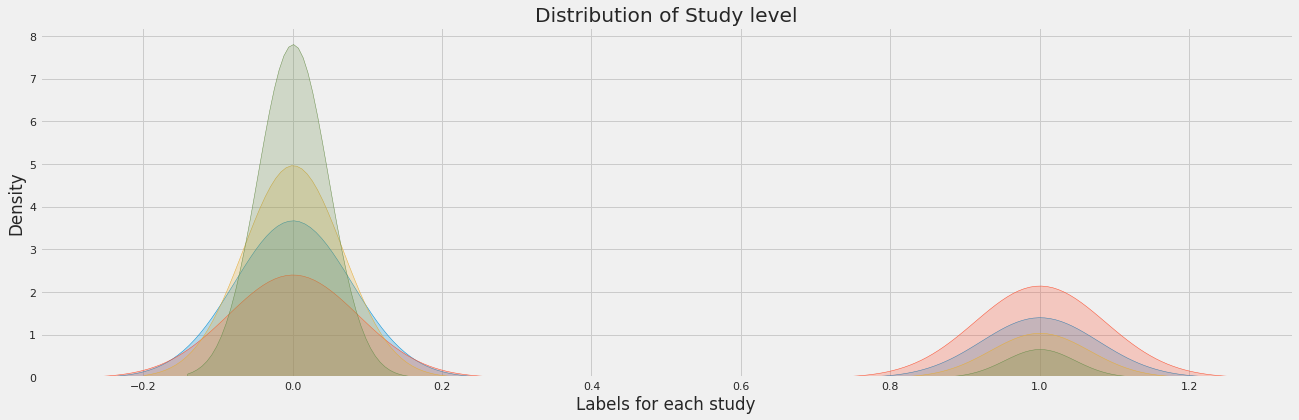

In [ ]:
plt.figure(figsize=(20, 6))
sns.kdeplot(train_study_df['Negative for Pneumonia'], shade=True)
sns.kdeplot(train_study_df['Typical Appearance'], shade=True)
sns.kdeplot(train_study_df['Indeterminate Appearance'], shade=True)
sns.kdeplot(train_study_df['Atypical Appearance'], shade=True)

# Labeling of plot
plt.xlabel('Labels for each study'); plt.ylabel('Density'); plt.title('Distribution of Study level');

### Distribution of Negative for Pneumonia

In [ ]:
fig = px.bar(train_study_df, 
             x=train_study_df['Negative for Pneumonia'].value_counts().index, 
             y=train_study_df['Negative for Pneumonia'].value_counts(),
             color=['0','1'])
fig.update_traces(marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(title_text="Distribution of Negative for Pneumonia")
fig.show()

### Distribution of Typical Appearance

In [ ]:
fig = px.bar(train_study_df, 
             x=train_study_df['Typical Appearance'].value_counts().index, 
             y=train_study_df['Typical Appearance'].value_counts(),
             color=['0','1'])
fig.update_traces(marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(title_text="Distribution of Typical Appearance")
fig.show()

### Distribution of Indeterminate Appearance

In [ ]:
fig = px.bar(train_study_df, 
             x=train_study_df['Indeterminate Appearance'].value_counts().index, 
             y=train_study_df['Indeterminate Appearance'].value_counts(),
             color=['0','1'])
fig.update_traces(marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(title_text="Distribution of Indeterminate Appearance")
fig.show()

### Distribution of Indeterminate Appearance

In [ ]:
fig = px.bar(train_study_df, 
             x=train_study_df['Atypical Appearance'].value_counts().index, 
             y=train_study_df['Atypical Appearance'].value_counts(),
             color=['0','1'])
fig.update_traces(marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(title_text="Distribution of Indeterminate Appearance")
fig.show()

## 4.2 Basic Data Exploration for `Image level` ✅

In [ ]:
train_image_df.head()

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]",opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867.79767, 'height': 999.78214}, {'x': 1792.69064, 'y': 402.5525, 'width': 617.02734, 'height': 1204.358}]",opacity 1 677.42216 197.97662 1545.21983 1197.75876 opacity 1 1792.69064 402.5525 2409.71798 1606.9105,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.00012, 'height': 604}]",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'height': 1106}, {'x': 2578.56661, 'y': 998.66667, 'width': 662.66667, 'height': 1120}]",opacity 1 623.23328 1050 1337.23328 2156 opacity 1 2578.56661 998.66667 3241.23328 2118.66667,dfd9fdd85a3e


`StudyInstanceUID` seems same `id` in `study level`.
- https://www.kaggle.com/yujiariyasu/plot-3positive-classes

In [ ]:
# merge study csv
train_study_df['StudyInstanceUID'] = train_study_df['id'].apply(lambda x: x.replace('_study', ''))
del train_study_df['id']
train = train_image_df.merge(train_study_df, on='StudyInstanceUID')
train.head()

,id,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]",opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472,5776db0cec75,0,1,0,0
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,1,0,0,0
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867.79767, 'height': 999.78214}, {'x': 1792.69064, 'y': 402.5525, 'width': 617.02734, 'height': 1204.358}]",opacity 1 677.42216 197.97662 1545.21983 1197.75876 opacity 1 1792.69064 402.5525 2409.71798 1606.9105,9d514ce429a7,0,1,0,0
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.00012, 'height': 604}]",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,0,0,0,1
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'height': 1106}, {'x': 2578.56661, 'y': 998.66667, 'width': 662.66667, 'height': 1120}]",opacity 1 623.23328 1050 1337.23328 2156 opacity 1 2578.56661 998.66667 3241.23328 2118.66667,dfd9fdd85a3e,0,1,0,0


In `image level` df, Most of the data is related to the `bboxes`.
(Exactly `labels`, `confedence scores`, `bboxes`)

When looking at the `.dcm` images, we will use that information to draw the bboxes.

# 5. Visualising Images : DICOM 🗺️ 

In [ ]:
dataset_dir = Path('../input/siim-covid19-detection')

In [ ]:
'''
https://www.kaggle.com/trungthanhnguyen0502/eda-vinbigdata-chest-x-ray-abnormalities
'''
def dicom2array(path, voi_lut=True, fix_monochrome=True):
    dicom = pydicom.read_file(path)
    # VOI LUT (if available by DICOM device) is used to
    # transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data
        
    
def plot_img(img, size=(7, 7), is_rgb=True, title="", cmap='gray'):
    plt.figure(figsize=size)
    plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()


def plot_imgs(imgs, cols=2, size=7, is_rgb=True, title="", cmap='gray', img_size=(500,500)):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        if img_size is not None:
            img = cv2.resize(img, img_size)
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()

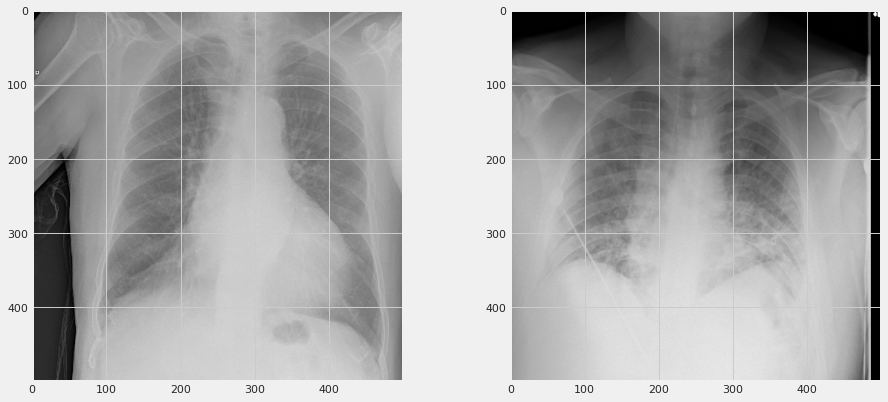

In [ ]:
dicom_paths = get_dicom_files(dataset_dir/'train')
imgs = [dicom2array(path) for path in dicom_paths[:2]]
plot_imgs(imgs)

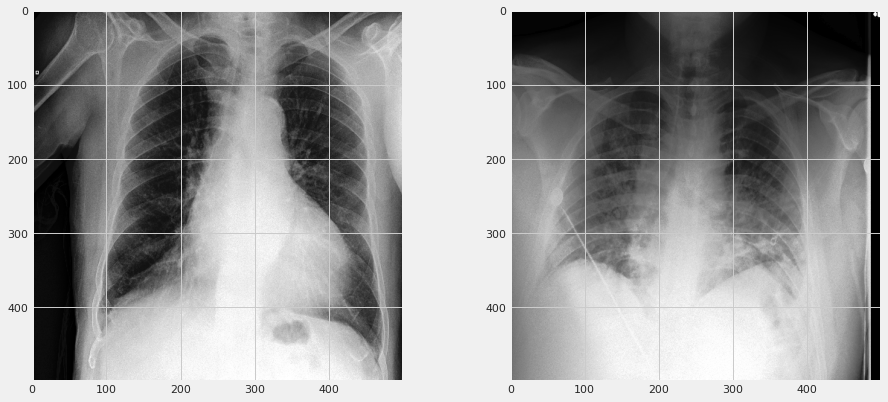

In [ ]:
# preprocess - equalize histogram

imgs = [exposure.equalize_hist(img) for img in imgs]
plot_imgs(imgs)

# 6. Visualizing Bounding Box 📦

For visualizing BBox, I will use `class_id`, [`x_min`, `y_min`, `x_max`, `y_max`] in `label` column. 


Please see following EDA. For reference:
 - https://www.kaggle.com/yujiariyasu/plot-3positive-classes
 - https://www.kaggle.com/tanlikesmath/siim-covid-19-detection-a-simple-eda

class_id
- `Typical Appearance`, `Indeterminate Appearance`, `Atypical Appearance`, or `negative`

In [ ]:
train.head()

,id,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]",opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472,5776db0cec75,0,1,0,0
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,1,0,0,0
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867.79767, 'height': 999.78214}, {'x': 1792.69064, 'y': 402.5525, 'width': 617.02734, 'height': 1204.358}]",opacity 1 677.42216 197.97662 1545.21983 1197.75876 opacity 1 1792.69064 402.5525 2409.71798 1606.9105,9d514ce429a7,0,1,0,0
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.00012, 'height': 604}]",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,0,0,0,1
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'height': 1106}, {'x': 2578.56661, 'y': 998.66667, 'width': 662.66667, 'height': 1120}]",opacity 1 623.23328 1050 1337.23328 2156 opacity 1 2578.56661 998.66667 3241.23328 2118.66667,dfd9fdd85a3e,0,1,0,0


we already know that `2048` bboxes seems missing in `train`.

In [ ]:
train.isnull().sum()

id                             0
boxes                       2040
label                          0
StudyInstanceUID               0
Negative for Pneumonia         0
Typical Appearance             0
Indeterminate Appearance       0
Atypical Appearance            0
dtype: int64

In [ ]:
class_names = ['Typical Appearance', 'Indeterminate Appearance', 'Atypical Appearance']

In [ ]:
'''
https://www.kaggle.com/yujiariyasu/plot-3positive-classes
'''

label2color = {
    '[1, 0, 0]': [255,0,0], # Typical Appearance
    '[0, 1, 0]': [0,255,0], # Indeterminate Appearance
    '[0, 0, 1]': [0,0,255], # Atypical Appearance
}

def plot_bboxes_with_label(label_name, n):
    print('Typical Appearance: ' + Fore.RED + 'Red',Style.RESET_ALL)
    print('Indeterminate Appearance: '  + Fore.GREEN + 'Green',Style.RESET_ALL)
    print('Atypical Appearance: ' + Fore.BLUE + 'Blue',Style.RESET_ALL)
    
    imgs = []
    thickness = 2
    scale = 5
    
    if label_name == 'Negative for Pneumonia':
        flag = 0
    else:
        flag = 1
    
    for _, row in train[train[label_name]==flag].iloc[:n].iterrows():
        study_id = row['StudyInstanceUID']
        img_path = glob.glob(f'{dataset_dir}/train/{study_id}/*/*')[0]
        img = dicom2array(path=img_path)
        img = cv2.resize(img, None, fx=1/scale, fy=1/scale)
        img = np.stack([img, img, img], axis=-1)

        claz = row[class_names].values
        color = label2color[str(claz.tolist())]

        bboxes = []
        bbox = []
        for i, l in enumerate(row['label'].split(' ')):
            '''
            Add comments for others
            '''
            # ================================================================
            # labels, confidence, x_min, y_min, width, height == 6 or NaN == 1
            # ================================================================
            if (i % 6 == 0) | (i % 6 == 1):
                continue
            bbox.append(float(l)/scale)
            if i % 6 == 5:
                bboxes.append(bbox)
                bbox = []
        for box in bboxes:
            img = cv2.rectangle(
                img,
                (int(box[0]), int(box[1])),
                (int(box[2]), int(box[3])),
                color, thickness
        )
        img = cv2.resize(img, (512,512))
        imgs.append(img)

    plot_imgs(imgs, cmap=None)
    
    del img, imgs, bbox, bboxes

## Visualizing `Negative for Pneumonia`

Typical Appearance: Red 
Indeterminate Appearance: Green 
Atypical Appearance: Blue 


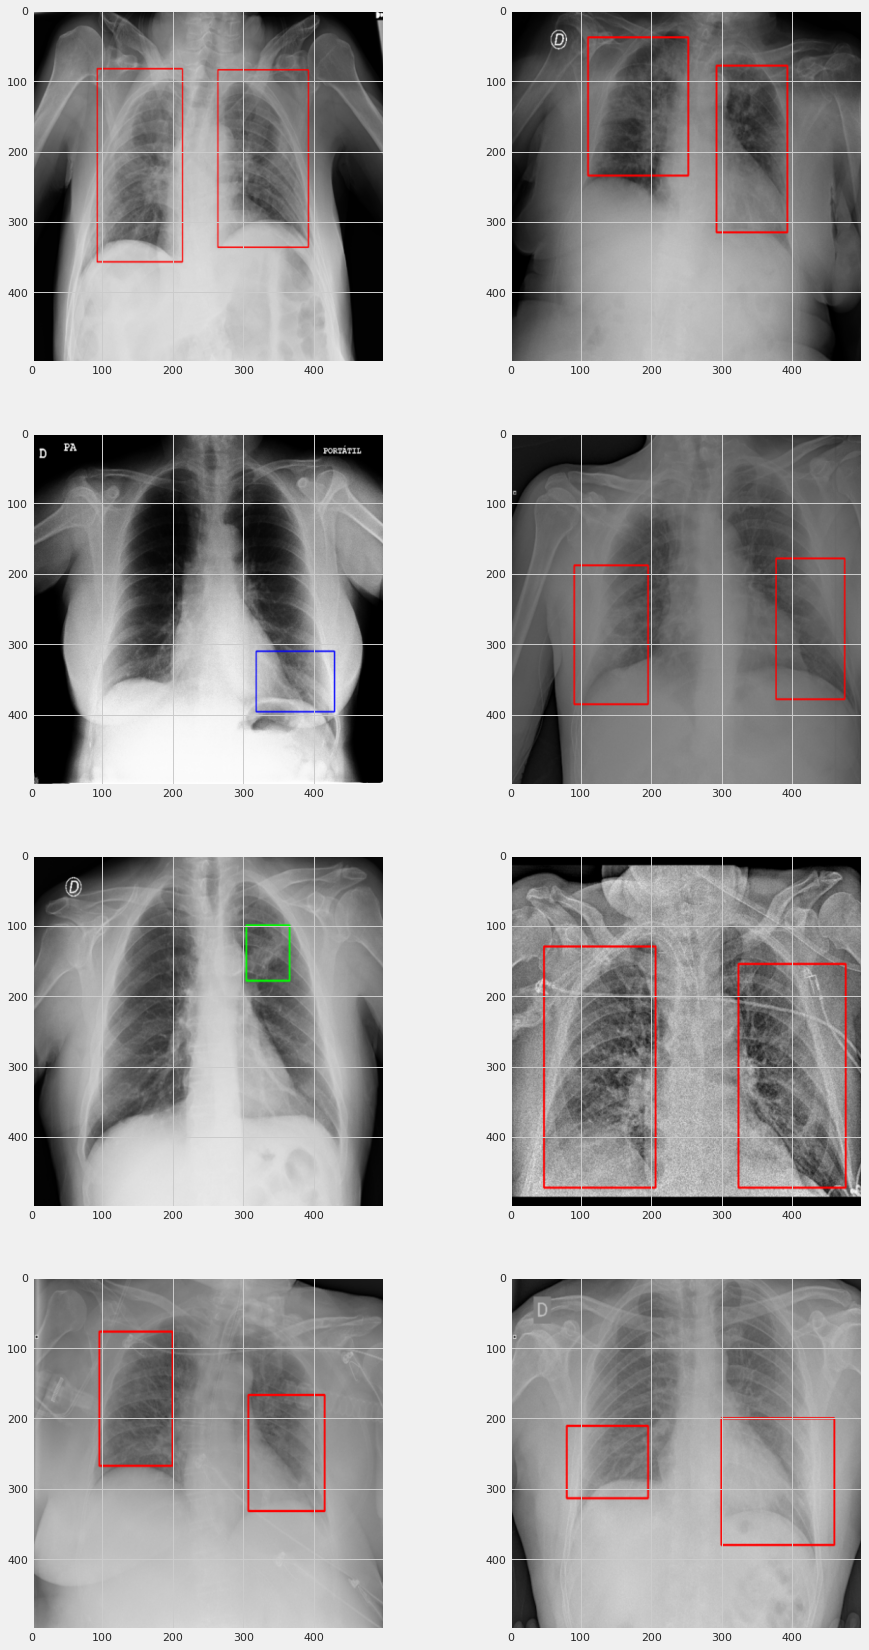

In [ ]:
plot_bboxes_with_label('Negative for Pneumonia', 8)

## Visualizing `Typical Appearance`

Typical Appearance: Red 
Indeterminate Appearance: Green 
Atypical Appearance: Blue 


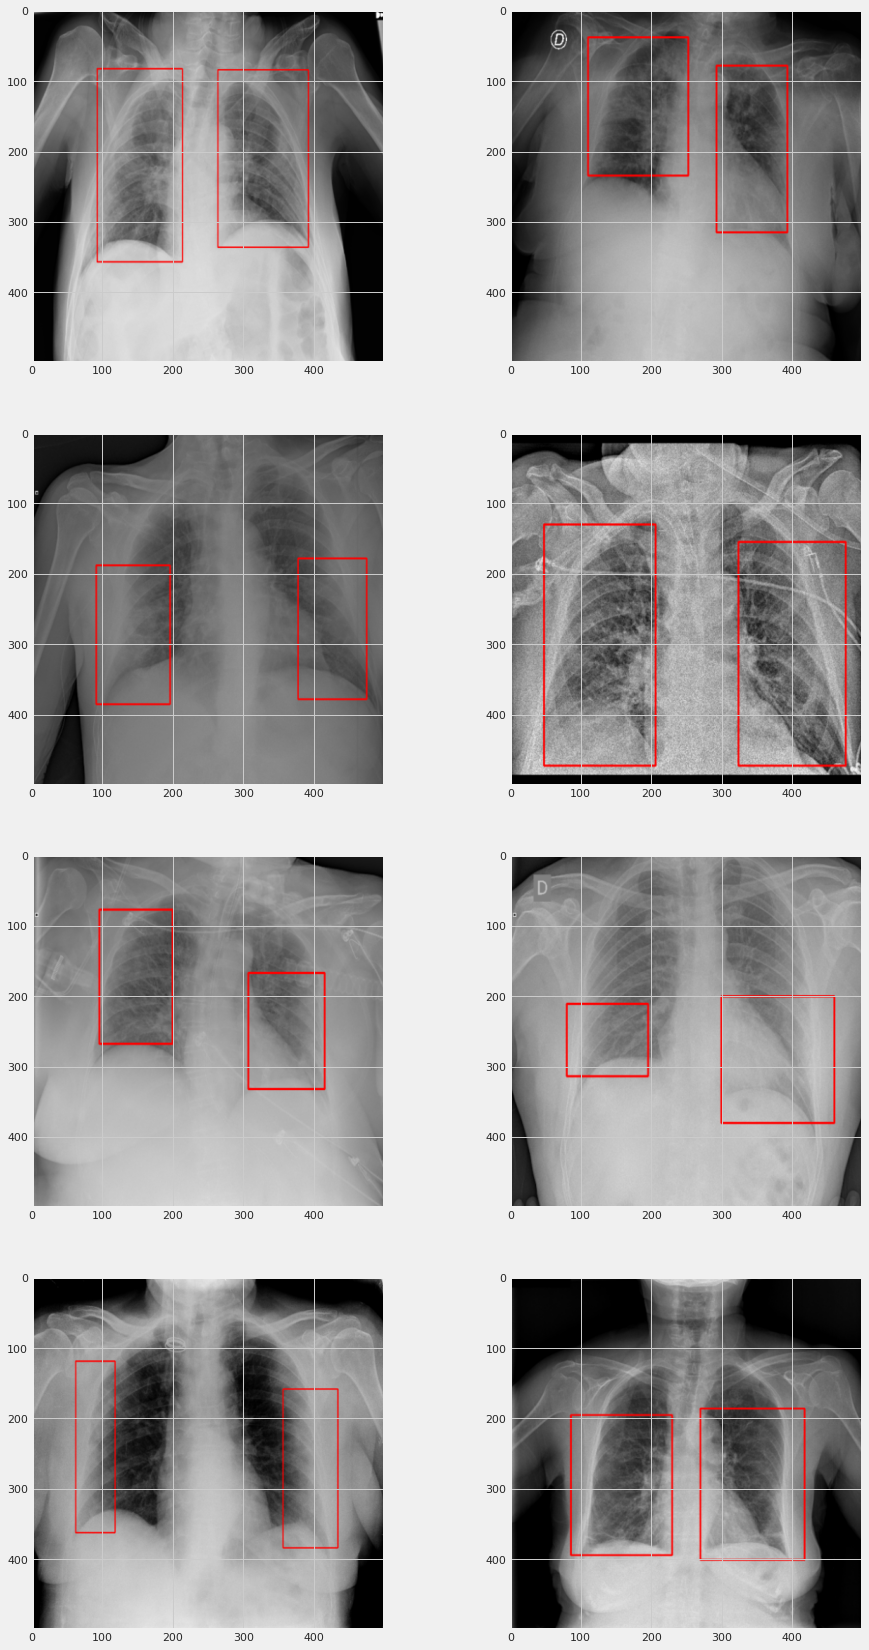

In [ ]:
plot_bboxes_with_label('Typical Appearance', 8)

## Visualizing `Indeterminate Appearance`

Typical Appearance: Red 
Indeterminate Appearance: Green 
Atypical Appearance: Blue 


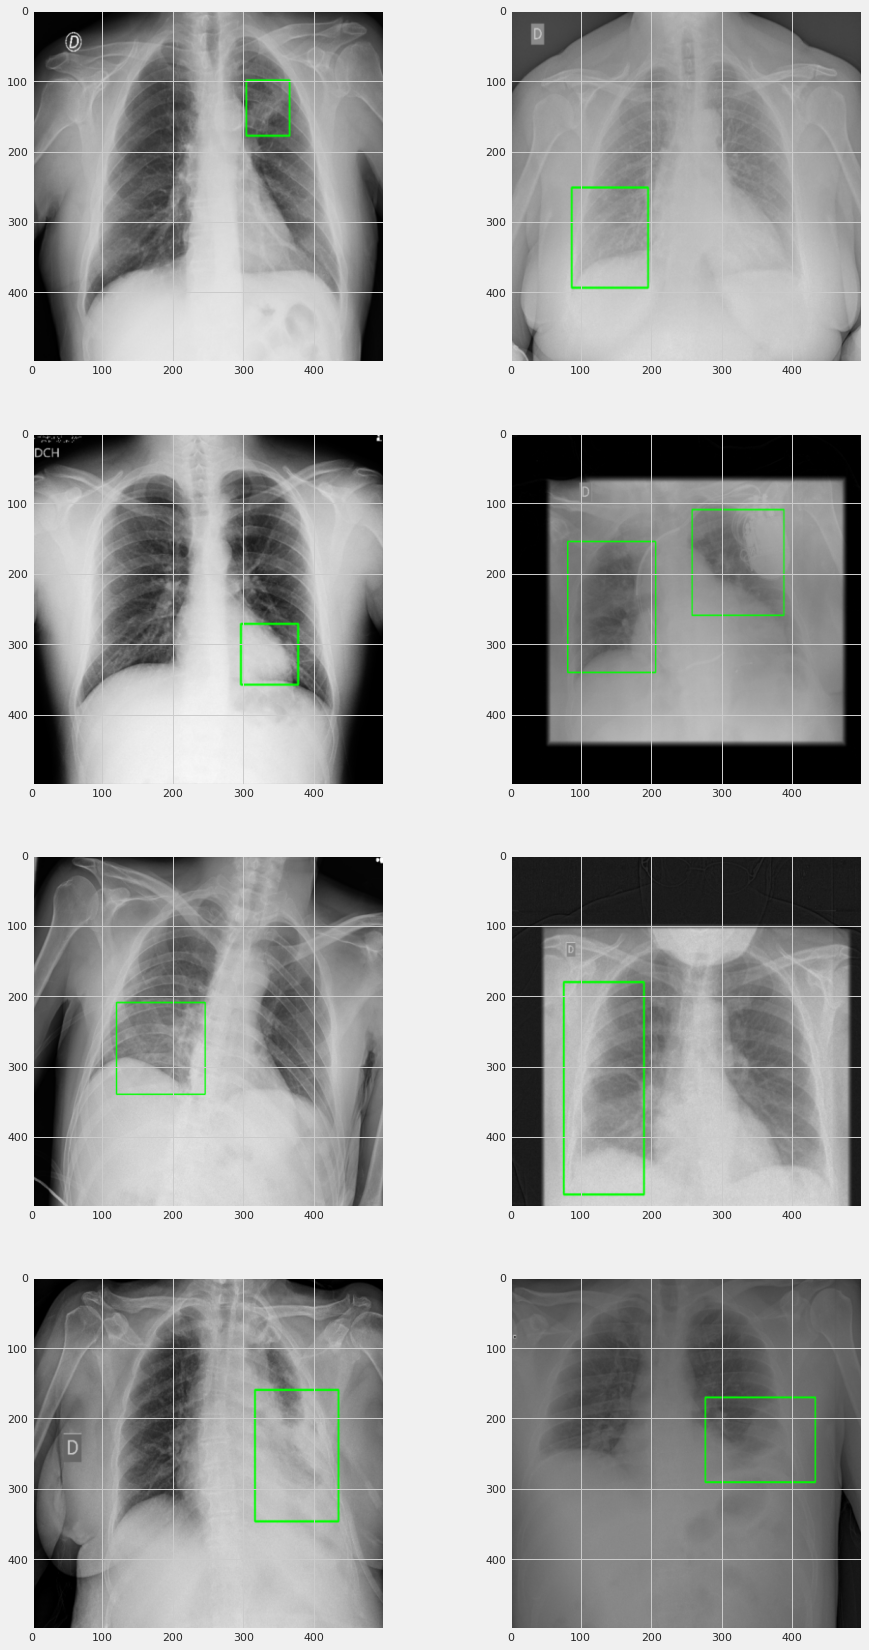

In [ ]:
plot_bboxes_with_label('Indeterminate Appearance', 8)

# 7. Etc. - Pandas Profiling 🌤️

In [ ]:
train_study_df = pd.read_csv('../input/siim-covid19-detection/train_study_level.csv')
train_image_df = pd.read_csv('../input/siim-covid19-detection/train_image_level.csv')

In [ ]:
from pandas_profiling import ProfileReport
profile_study = ProfileReport(train_study_df, title="Pandas Profiling Report - Train Study df")
profile_study.to_widgets()

Summarize dataset:   0%|          | 0/18 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
profile_image = ProfileReport(train_image_df, title="Pandas Profiling Report - Train Image df")
profile_image.to_widgets()

Summarize dataset:   0%|          | 0/17 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]